# Geodatenanalyse 1

## Tag 4 / Block 2 / Übung 11: Interpolationsmethoden: Kriging

 Folgende Python Packages, bzw. Libraries enthalten verschiedene, nützliche Funktionen für die Interpolation von räumlichen Daten mit Hilfe von Kriging: 
 
 - SciKit GStat: bietet detaillierte Möglichkeiten zur Analyse der Variogramme mit verschiedenen Modellen, allerdings nur für Ordinary Kriging (d.h. Daten ohne Trend oder drift) https://mmaelicke.github.io/scikit-gstat/install.html
 
 - PyKrige: beinhaltete eine Implementierung von Ordinary und Universal Kriging, dafür aber weniger Funktionalität für eine detaillierte Variogrammanalyse https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html

### 1. SciKit GStat

Lest wie in der letzten Übung zuerst die Daten aus `interp_data.csv` einlesen. 



In [3]:
import pandas as pd
data = pd.read_csv('interp_data.csv', sep=';', encoding='cp1252')

Erstellt zunächst mit `skgstat.Variogram()` eine Visualisierung der Semivarianz. 

Erzeugt dafür ein Variogram-Objekt mit der Funktion `skgstat.Variogram()`. Als Inputs werden die Koordinaten der Daten als Array mit der Dimension (m, n), sowie die Messwerte benötigt. Hinweis: mit `DataFrame[...].values` und den entsprechenden Indizes in der eckigen Klammer könnt Ihr die Werte als Arrays aus dem Datensatz extrahieren. 

Die graphische Darstellung erfolgt mit `VariogramObjekt.plot()` (Hinweis: setzt an das Ende dieser Zeile ein ";"). 

Je nach Rechenleistung Eures PCs kann die Ausführung einen Augenblick dauern. 

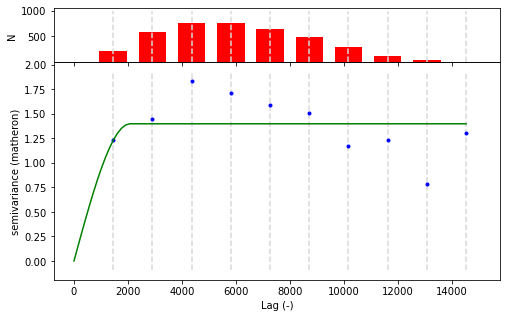

In [5]:
from skgstat import Variogram, OrdinaryKriging

Var = Variogram(data[['Rechtswert', 'Hochwert']].values, data.GWT)
Var.plot();

Am Histogram oben ist zu erkennen, dass Werte im Bereich von Lags über 8.000 nicht gut durch die Daten unterstützt werden. Daher sollten wir die Größe der berücksichtigten Lags entsprechend reduzieren, mit (`V-Objekt.maxlag = 8000`). 

Da wir über 90 Messwerte haben können wir außerdem die Anzahl der Lag-Klassen etwas erhöhen (`V-Objekt.n_lags=15`). Lasst Euch anschliepßend das veränderte Variogram anzeigen und vergleicht es mit dem von oben. 

In [ ]:
Var.maxlag = 8000
Var.n_lags = 15
Var.plot(show=False);

Die Anpassung sieht besonders im Bereich der kurzen Distanzen (niedriege Lags) visuell nicht sehr überzeugend aus. Gerade dieser Bereich ist jedoch wichtig für die Bestimmung der Gewichte für das Kriging. 

Wenn nicht genauer spezifiziert nimmt `Variogram()` ein sphärisches Varianzmodell an. Testet nun neben diesem noch andere Modelle ("exponential" und "gaussian") über die Angabe von `V-Objekt.model ='name'`, und plottet die verschiedenen Anpassungen zum Vergleich nebeneinander. 

Die Variogram-Klasse hat außerdem eine eingebaute Funktionalität um den RMSE (`rmse`) der Anpassung zu berechnen: `V-Objekt.rmse`. Lasst Euch damit auch die Fehler der Anpassungen ausgeben, und vergleicht diese mit dem optischen Eindruck der Anpassung. 


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
Var.model = 'spherical'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('spherical', Var.rmse))

ax = axs[1]
Var.model = 'exponential'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('exponential', Var.rmse))

ax = axs[2]
Var.model = 'gaussian'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('gaussian', Var.rmse))
plt.show()

Wählt nun das passenste Variogramm-Modell auswähl und führt ein Ordinary Kriging (`skgstat.OrdinaryKriging()`) durch. Dafür sind folgende Schritte nötig: 

- für das Variogramm-Objekt von oben das gewünschte Modell angeben. 

- Interpolationsobjekt definieren: `OrdinaryKriging(Variogramm, min_points=2, max_points=8)`. Die Auswahl der minimal und maximal berücksichtigten Anzahl an Nachbarpunkten orientiert sich an Anzahl und Abstand zwischen den Messpunkten (eine Art Optimierungsparameter)

- gleichmäßiges Grid mit den zu interpolierenden Koordinaten erstellen (siehe letzte Übung)

- Die `.transform()` Funktion auf das Interpolationsobjekt anwenden: Die x- und y-Koordinaten werden dabei als einzelne 1D Numpy Arrays benötigt. Erzeugen könnt Ihr diese z.B. über `array.flatten()` 

- Ergebnis mit `plt.imshow()` visualisieren. Dafür müsst Ihr den eben erzeugten Array mit den interpolierten Werten wieder umstruktieren, d.h. in seine ursprüngliche Form bringen, z.B. mit array.reshape(dimensions)

- plottet auch die Lage der Messpunkte zu dem interpolierten Raster. 

In [ ]:
from skgstat import OrdinaryKriging
import numpy as np

Var.model = 'exponential'
ok = OrdinaryKriging(Var, min_points=2, max_points=8)

extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]
grid_x, grid_y = np.mgrid[x_min:x_max:400, y_min:y_max:400]

field = ok.transform(grid_x.flatten(), grid_y.flatten()).reshape(grid_x.shape)

plt.figure(figsize=(8, 5))
plt.imshow(field.T, origin='lower', extent=extent, cmap='plasma')
plt.title('Ordinary Kriging')
plt.plot(data.Rechtswert, data.Hochwert, '+k')
plt.colorbar()
plt.show()

Das sieht nun gar nicht mal schlecht aus :)

### 2. PyKrige

Wir wollen nun auch die Grundwasserhöhen interpolieren (Parameter "GWHoehe"). Erzeugt zuerst wieder eine einfache Kartendarstellung, z.B. als Scatterplot, und überpfüft die Werte visuell auf einen möglichen Trend oder Drift. 

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(6, 4))
ax = fig.add_subplot(1,1,1)

plt.scatter(data.Rechtswert, data.Hochwert, c=data.GWHoehe, cmap='Blues')
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.title('Grundwassertemperatur [°C]')
plt.grid(c='k', alpha=0.2)
plt.show()

Hier ist ein eindeutiger Trend in den Grundwasserhöhen zu sehen. Folglich sollte die Interpolation mit Universal Kriging unter Berücksichtigung des regionalen Trends durchgeführt werden. 

Erzeugt nun zuerst wieder mit `pykrige.uk.UniversalKriging` ein Interpolationsobjekt, mit den Inputs: x-Koordinaten, y-Koorinaten, Messwerte (alle drei jeweils array-like), variogram_model='exponential', `drift_terms=["regional_linear"]`. 

mit `.execute()` könnt Ihr dann über dieses Objekt die Interpolation ausführen. Benötigte Inputs sind: "points" (als string der den Grid-Style definiert), x_grid (1D Array), y_grid (1D Array). Als Outputs gibt die Funktion die interpolierten Werte an den Grid-Koordinaten, und die Varianz der geschätzten Werte zurück.

Schließlich könnt ihr (analog zu oben) das interpolierte Grid und die Varianz wieder auf ihre ursprünglichen Dimensionen transformieren, und z.B. mit `plt.imshow()` visualisieren. 

In [ ]:
from pykrige.uk import UniversalKriging

UK = UniversalKriging(data.Rechtswert, data.Hochwert, data.GWHoehe,
                      variogram_model="exponential", drift_terms=["regional_linear"])

z, ss = UK.execute("points", grid_x.flatten(), grid_y.flatten())
z = z.reshape(grid_x.shape)
ss = ss.reshape(grid_x.shape)

fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(1,2,1)
art = ax.imshow(z.T, origin='lower', extent=extent, cmap='Blues')
ax.plot(data.Rechtswert, data.Hochwert, '+k')
ax.set_title('Universal Kriging')
plt.colorbar(art, shrink=0.67)

ax1 = fig.add_subplot(1,2,2)
art2 = ax1.imshow(ss.T, origin='lower', extent=extent, cmap='viridis')
ax1.plot(data.Rechtswert, data.Hochwert, '+w')
ax1.set_title('Kriging Varianz')
plt.colorbar(art2, shrink=0.67)

plt.show()

Diese Daten ergeben ein glattes, interpoliertes Raster. Aus der Varianz könnt Ihr nun auch die Unsicherheit der interpolierten Werte abschätzen. Wie würdet Ihr diese einordnen (groß, klein, vertretbar, ...)? Was fällt bei der räumlichen Verteilung auf?

## Ende

### Referenzen

Menberg et al. (2013): Long-term evolution of anthropogenic heat fluxes into a subsurface urban heat island, Environ. Sci. Technol. 47(17) (2013) 9747-9755

https://mmaelicke.github.io/scikit-gstat/tutorials/01_getting_started.html